# Applying apodization to images

I all the data frequency domain as spectra of 1000 averages, I was wondering if I could apodize even though I hadn't saved the data in the time domain.

The modulus of a convolution satisfies the inequality:

\begin{align}
\lvert u \ast v \rvert \leq \lvert u \rvert \ast \lvert v \rvert
\end{align}

In my case, $u$ is is a real function ($\rm{sinc}$) function

You should also note that when looking at the apodized spectrum, you are taking the Fourier Transform of the product of two *real* functions.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import clipboard_and_style_sheet as cr
from scipy.integrate import simpson
from tqdm import tqdm
import scipy.constants as sc
import os

cr.style_sheet()

In [5]:
if os.name == "nt":
    # this would be something else on the GaGe computer...
    path_folder = (
        r"C:\\Users\\pchan\\SynologyDrive\\Research_Projects\\Microscope\\Images/"
    )

else:
    # linux partition
    # path_folder = r"/Users/peterchang/SynologyDrive/Research_Projects" \
    #               r"/Microscope/Images/"
    path_folder = r"/Volumes/Peter SSD/Research_Projects/Microscope/Images/"

list_filter = np.array(
    [
        [0, 2],
        [249, 251],
        [279, 283],
        [333, 336],
        [438, 440],
        [499, 500],
    ]
)

In [6]:
def filt(freq, ll, ul, x, type="bp"):
    if type == "bp":
        return np.where(np.logical_and(freq > ll, freq < ul), x, 0.0)

    elif type == "notch":
        return np.where(np.logical_or(freq < ll, freq > ul), x, 0.0)


def apply_filt(ft, lst_fltrs=list_filter):
    rfreq = np.fft.rfftfreq((len(ft) - 1) * 2, 1e-9) * 1e-6
    for f in lst_fltrs:
        ft = filt(rfreq, *f, ft, "notch")

    return ft


def num_4():
    path = path_folder + "11-08-2022/"
    s = np.load(
        path + "stage1_5932_6066_stage2_8478_8575p5_step_2p5_ppifg_74180.npy",
        mmap_mode="r",
    )
    s = np.transpose(s, axes=[1, 0, 2])
    x = np.arange(5932, 6066, 2.5)
    y = np.arange(8478, 8575.5 + 2.5, 2.5)

    return x, y, s


def smallest_bar():
    path = path_folder + "11-08-2022/"
    s = np.load(
        path + "stage1_6274_6460_stage2_8593_8883_step_2p5_ppifg_74180.npy",
        mmap_mode="r",
    )
    s = np.transpose(s, axes=[1, 0, 2])
    x = np.arange(6274, 6460, 2.5)
    y = np.arange(8593, 8883 + 2.5, 2.5)

    return x, y, s

In [7]:
x, y, s = num_4()
shape = s.shape
s = s.reshape((s.shape[0] * s.shape[1], s.shape[2]))
for n, i in enumerate(tqdm(s)):
    s[n] = apply_filt(i)
s = s.reshape(shape)
t = np.fft.ifftshift(np.fft.irfft(s, axis=-1), axes=-1)

resolution = 100
ppifg = 74180
center = ppifg // 2
window = int(np.round(ppifg / resolution))
t_a = t[:, :, center - window // 2 : center + window // 2]
s_a = np.fft.rfft(np.fft.fftshift(t_a, axes=-1), axis=-1)
s_a = abs(s_a)

100%|██████████| 2160/2160 [00:01<00:00, 2060.28it/s]


In [8]:
absorption = s / s[0, 0]
absorbance = -np.log(absorption)

absorption_a = s_a / s_a[0, 0]
absorbance_a = -np.log(absorption_a)

/var/folders/21/b2v3t9rs31qgytc4v7gf2wlh0000gn/T/ipykernel_6735/2869840698.py:1: RuntimeWarning: invalid value encountered in divide
  absorption = s / s[0, 0]


In [9]:
nu = np.fft.rfftfreq(ppifg - 1, 1e-9) * ppifg
nu += nu[-1] * 2
wl = sc.c * 1e6 / nu
wl_ll, wl_ul = 3.25, 3.6
ind_ll, ind_ul = np.argmin(abs(wl - wl_ul)), np.argmin(abs(wl - wl_ll))

img = simpson(absorbance[:, :, ind_ll:ind_ul])
img -= img.min()
img *= -1

In [10]:
nu_a = np.fft.rfftfreq(window, 1e-9) * ppifg
nu_a += nu_a[-1] * 2
wl_a = sc.c * 1e6 / nu_a
ind_ll_a, ind_ul_a = np.argmin(abs(wl_a - wl_ul)), np.argmin(abs(wl_a - wl_ll))

img_a = simpson(absorbance_a[:, :, ind_ll_a:ind_ul_a])
img_a -= img_a.min()
img_a *= -1

In [11]:
%matplotlib inline

(3.2, 3.65)

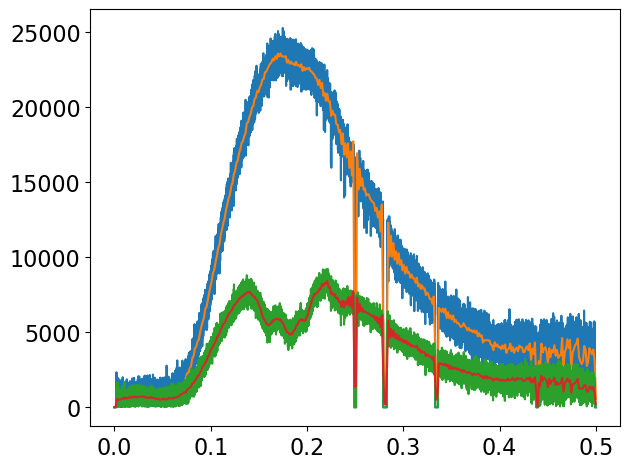

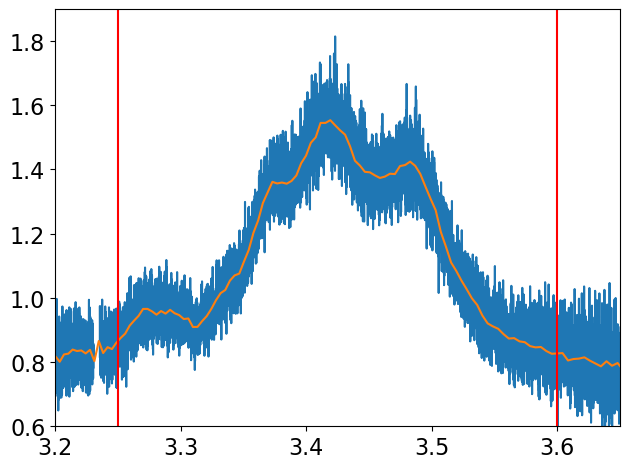

In [12]:
plt.figure()
plt.plot(np.fft.rfftfreq(ppifg - 1), s[0, 0])
plt.plot(np.fft.rfftfreq(window), s_a[0, 0])
plt.plot(np.fft.rfftfreq(ppifg - 1), s[13, 27])
plt.plot(np.fft.rfftfreq(window), s_a[13, 27])

plt.figure()
plt.plot(wl, absorbance[13, 27])
plt.plot(wl_a, absorbance_a[13, 27])
[plt.axvline(i, color="r") for i in [wl_ll, wl_ul]]
plt.ylim(0.6, 1.9)
plt.xlim(3.2, 3.65)

The spectrum plots above makes it look like apodization worked.

I might also point out that you don't care about phase information. The phase in the averaging of fft's matter because $\lvert r_1e^{i\theta_1} + r_2e^{i\theta_2} \rvert \neq \lvert r_1 \rvert + \lvert r_2 \rvert$. However, for apodization where you only have *one* interferogram, throwing out the phase info before apodizing the time domain should not affect the modulus of the apodized spectrum! 

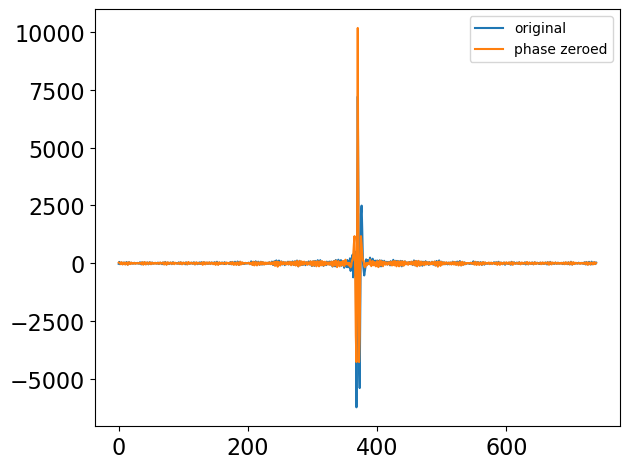

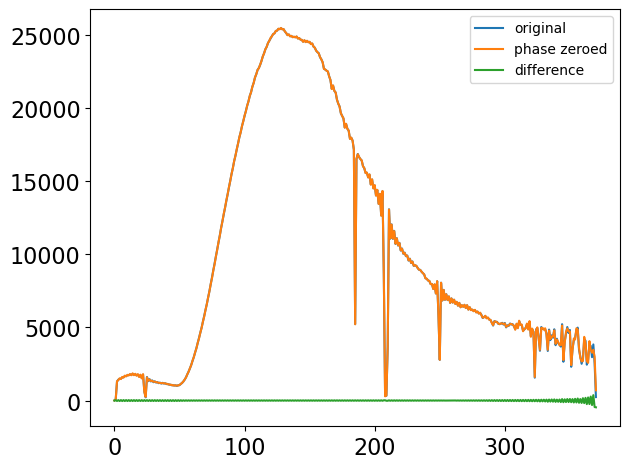

In [ ]:
if os.name == "nt":
    path = (
        r"C:\Users\pchan\SynologyDrive\Research_Projects\Microscope/"
        r"Python_Workspace\data\phase_corrected/"
    )
else:
    path = (
        r"/Volumes/Peter SSD/Research_Projects/Microscope/Python_Workspace"
        r"/data/phase_corrected/"
    )

avg = np.load(path + "bckgnd/avg_bckgnd.npy", mmap_mode="r")
ft = dpc.rfft(avg)

p = np.arctan2(ft.imag, ft.real)
ft_zero_phase = ft * np.exp(-1j * p)
t_zero_phase = dpc.irfft(ft_zero_phase)

ppifg = 74180
center = ppifg // 2
window = 74180 // 100

t_a = avg[center - window // 2 : center + window // 2]
t_a_zero_phase = t_zero_phase[center - window // 2 : center + window // 2]

ft_a = dpc.rfft(t_a)
ft_a_zero_phase = dpc.rfft(t_a_zero_phase)

plt.figure()
plt.plot(t_a, label="original")
plt.plot(t_a_zero_phase, label="phase zeroed")
plt.legend(loc="best")

plt.figure()
plt.plot(abs(ft_a), label="original")
plt.plot(abs(ft_a_zero_phase), label="phase zeroed")
plt.plot(abs(ft_a) - abs(ft_a_zero_phase), label="difference")
plt.legend(loc="best")

However, as you can see from the generated images, there is not an SNR improvement to the image, seemingly from the fact that the number of points that you integrate over is significantly reduced. It more or less seems to be an exact trade off.

Text(0.5, 1.0, 'apodized image')

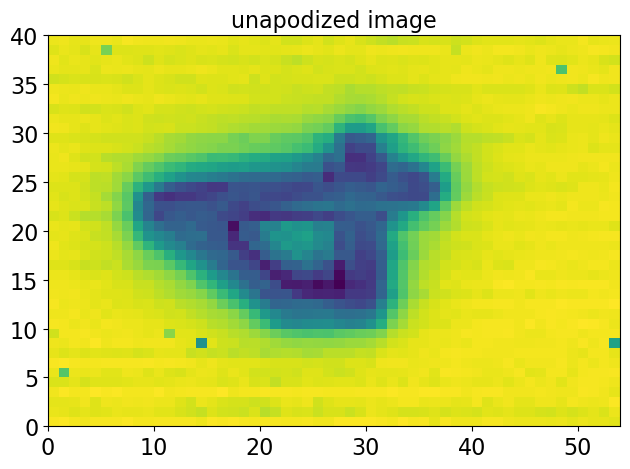

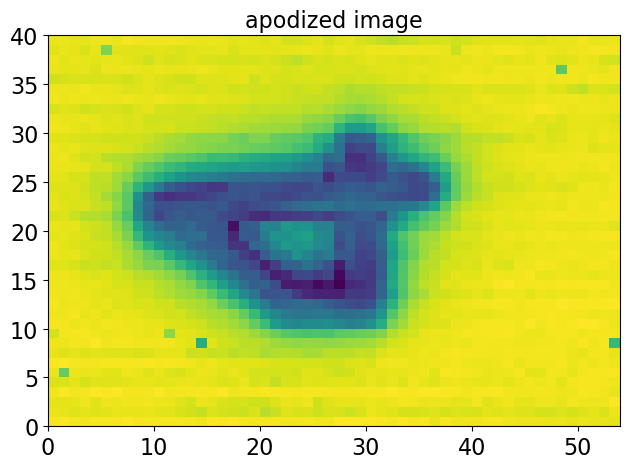

In [13]:
plt.figure()
plt.pcolormesh(img)
plt.title("unapodized image")

plt.figure()
plt.pcolormesh(img_a)
plt.title("apodized image")

This can be further illustrated by looking again at the static data. At 100 averages, the SNR clearly improves going from 1 $\rightarrow$ 100 GHz resolution in the gif below. However, the integrated absorbance does not change significantly!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import clipboard_and_style_sheet as cr
from scipy.integrate import simpson
from tqdm import tqdm
import scipy.constants as sc
import os
from include import digital_phase_correction as dpc  # better way to important I think

cr.style_sheet()

In [ ]:
if os.name == "nt":
    path = (
        r"C:\Users\pchan\SynologyDrive\Research_Projects\Microscope/"
        r"Python_Workspace\data\phase_corrected/"
    )
else:
    path = (
        r"/Volumes/Peter SSD/Research_Projects/Microscope/Python_Workspace"
        r"/data/phase_corrected/"
    )

In [ ]:
%matplotlib inline

100%|██████████| 99/99 [00:00<00:00, 2489.74it/s]


Text(0.5, 1.0, 'Integrated Absorbance vs. Resolution (100 Averages)')

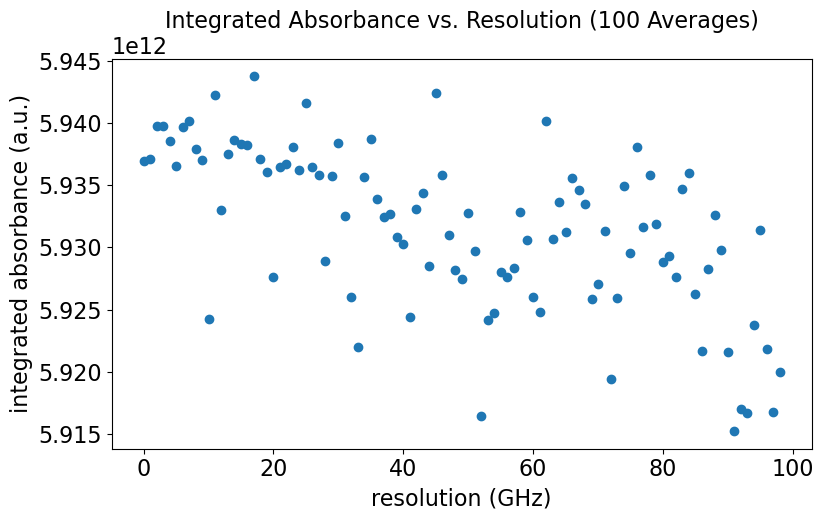

In [ ]:
data_bckgnd = np.load(  # taken on silicon
    path + "stage1_5116_stage2_8500_53856x74180_phase_corrected.npy",
    mmap_mode="r",
)

data_su8 = np.load(  # taken on silicon
    path + "stage1_5300_stage2_8970_53856x74180_phase_corrected.npy",
    mmap_mode="r",
)

N_avg = 100
avg_bckgnd = np.mean(data_bckgnd[:N_avg], axis=0)
avg_su8 = np.mean(data_su8[:N_avg], axis=0)

RESOLUTION = np.arange(1, 100)
AREA = np.zeros(len(RESOLUTION))
plot = False
save = False
if plot:
    fig, ax = plt.subplots(1, 1)
for n, r in enumerate(tqdm(RESOLUTION)):
    ppifg = 74180
    center = ppifg // 2
    window = int(np.round(ppifg / r))

    wl_ll, wl_ul = 3.25, 3.6
    nu_a = np.fft.rfftfreq(window, 1e-9) * ppifg
    nu_a += nu_a[-1] * 2
    wl_a = sc.c * 1e6 / nu_a
    ind_ll_a, ind_ul_a = np.argmin(abs(wl_a - wl_ul)), np.argmin(abs(wl_a - wl_ll))

    ft_bckgnd = dpc.rfft(avg_bckgnd[center - window // 2 : center + window // 2])
    ft_su8 = dpc.rfft(avg_su8[center - window // 2 : center + window // 2])

    absorption = abs(ft_su8) / abs(ft_bckgnd)
    absorbance = -np.log(absorption)
    # make sure you provide a frequency axis, or else the area won't be the
    # same since the number of points change but it would assume dx=1
    AREA[n] = simpson(absorbance[ind_ll_a:ind_ul_a], x=nu_a[ind_ll_a:ind_ul_a])

    if plot:
        ax.clear()
        ax.plot(wl_a[ind_ll_a:ind_ul_a], absorbance[ind_ll_a:ind_ul_a])
        if save:
            plt.savefig(f"fig/{n}.png")
        else:
            plt.pause(0.1)

fig = plt.figure(figsize=np.array([8.34, 5.3]))
plt.plot(AREA, "o")
plt.xlabel("resolution (GHz)")
plt.ylabel("integrated absorbance (a.u.)")
plt.title("Integrated Absorbance vs. Resolution (100 Averages)")

In [3]:
from IPython.display import Video
Video("media/su8_absorbance_with_averaging.mp4", embed=True, width=700)

The take away from this I think is that you can not really actually increase the imaging speed of the SU-8 on silicon using the current modality by apodizing. 

At least not if you're using the integrated absorbance as the contrast mechanism (which I had thought would be the natural one to use). 

However, in a bio-imaging experiment, the contrast instead becomes the spectral fitting. And that one should see an SNR improvement with apodization. That speed increase is what you look at in your other notebook (Microscope USAF Target SU-8 on Silicon.ipynb)